## Load & Calculate Perceptual Hash Value for each image in the dataset

In [1]:
import os
from PIL import Image
import imagehash
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ranksums
from scipy.stats import ttest_ind

def process_images(folder_path, hash_algorithm='phash', verbose=True):
    # List to store image file names, hashes, and labels
    data = []

    hash_functions = {
        'phash': imagehash.phash
    }

    if hash_algorithm not in hash_functions:
        raise ValueError(f"Unsupported hash algorithm. Choose from {list(hash_functions.keys())}.")

    hash_func = hash_functions[hash_algorithm]

    # Iterate over all files in the folder
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, file)
            try:
                # Open the image file
                image = Image.open(image_path)
                # Calculate the perceptual hash
                hash_value = hash_func(image)
                # Determine the class label based on the filename prefix
                if file.startswith('A'):
                    class_label = 'Autistic'
                elif file.startswith('N'):
                    class_label = 'Non_Autistic'
                else:
                    continue  # Skip files that don't match the expected prefix
                
                # Store the filename, hash, and class label
                data.append((file, str(hash_value), class_label))
                if verbose:
                    print(f'Processed {file}: {hash_value}')
            except Exception as e:
                print(f'Error processing {file}: {e}')

    return data


## Saving hash values to CSV file

In [2]:
def save_to_csv(data, csv_output_path):
    # Convert to DataFrame and save to CSV
    df = pd.DataFrame(data, columns=['filename', 'hash', 'class'])
    df.to_csv(csv_output_path, index=False)
    print(f'Saved dataset to {csv_output_path}')


In [ ]:
folder_path = '/dataset'
# Specify the path to save the CSV file
csv_output_path = 'image_hashes.csv'

# Process images
data = process_images(folder_path, hash_algorithm='phash', verbose=True)

# Save results to CSV
save_to_csv(data, csv_output_path)


Processed Autistic.0.jpg: ff7a6a6821a2c331
Processed Autistic.1.jpg: 953976e5d383c096
Processed Autistic.10.jpg: 9f6578683d74a590
Processed Autistic.100.jpg: c2b42b766e7a8b60
Processed Autistic.1000.jpg: 9f687a65b4c69328
Processed Autistic.1001.jpg: e18beea445293f94
Processed Autistic.1002.jpg: 94627b53f83f2a24
Processed Autistic.1003.jpg: f06903a4873b8f7a
Processed Autistic.1004.jpg: 957f5e600120def5
Processed Autistic.1005.jpg: c32e7bb5703d6092
Processed Autistic.1006.jpg: ba6a6865a4d297a9
Processed Autistic.1007.jpg: fee0e28594869e5a
Processed Autistic.1008.jpg: df7f06ec6820b984
Processed Autistic.1009.jpg: bc5e0ee0b4a79694
Processed Autistic.101.jpg: c0352ad1f982d737
Processed Autistic.1010.jpg: df1ff835e83080b2
Processed Autistic.1011.jpg: dbf828e0699785a5
Processed Autistic.1012.jpg: 83742a73342ddb1e
Processed Autistic.1013.jpg: c19b0fbcf8983878
Processed Autistic.1014.jpg: ea95a187b6cc2636
Processed Autistic.1015.jpg: ee3f25e0a5d194d0
Processed Autistic.1016.jpg: d4157ce16163949

## Load the hash values to dataframe 

In [3]:
# Load the dataset
df = pd.read_csv('image_hashes.csv')

# Display the first few rows of the dataset
print(df.head())

# Basic statistics
print(df['class'].value_counts())

# Calculate the length of the hash (to check for consistency)
df['hash_length'] = df['hash'].apply(len)
print(df['hash_length'].value_counts())




            filename              hash     class
0     Autistic.0.jpg  ff7a6a6821a2c331  Autistic
1     Autistic.1.jpg  953976e5d383c096  Autistic
2    Autistic.10.jpg  9f6578683d74a590  Autistic
3   Autistic.100.jpg  c2b42b766e7a8b60  Autistic
4  Autistic.1000.jpg  9f687a65b4c69328  Autistic
class
Autistic        1270
Non_Autistic    1270
Name: count, dtype: int64
hash_length
16    2540
Name: count, dtype: int64


## Visualization of Hash Values

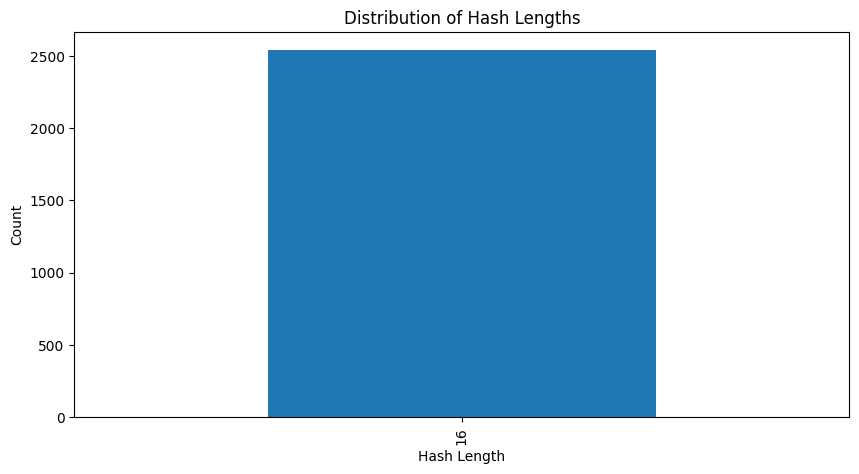

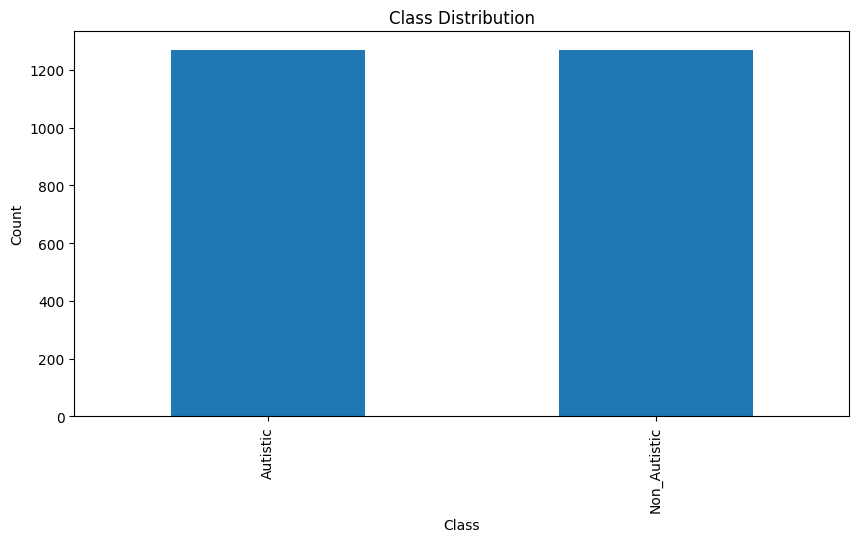

In [4]:
# Plot the distribution of hash lengths (should be consistent)
plt.figure(figsize=(10, 5))
df['hash_length'].value_counts().plot(kind='bar')
plt.title('Distribution of Hash Lengths')
plt.xlabel('Hash Length')
plt.ylabel('Count')
plt.show()

# Visualize the class distribution
plt.figure(figsize=(10, 5))
df['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

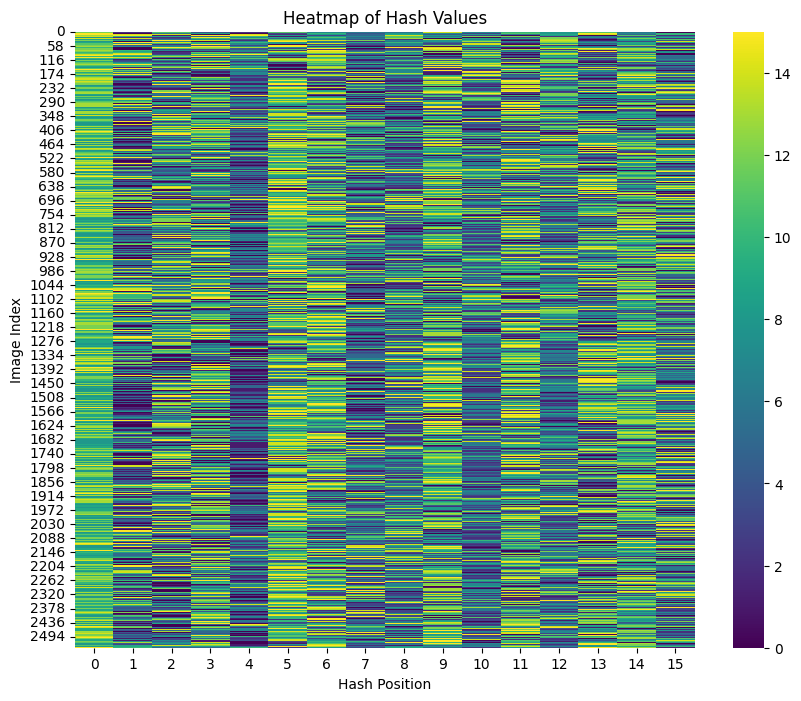

In [5]:
hash_matrix = df['hash'].apply(lambda x: np.array([int(c, 16) for c in x], dtype=np.uint8))
hash_matrix = np.vstack(hash_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(hash_matrix, cmap='viridis')
plt.title('Heatmap of Hash Values')
plt.xlabel('Hash Position')
plt.ylabel('Image Index')
plt.show()

## Hash Similarity Analysis

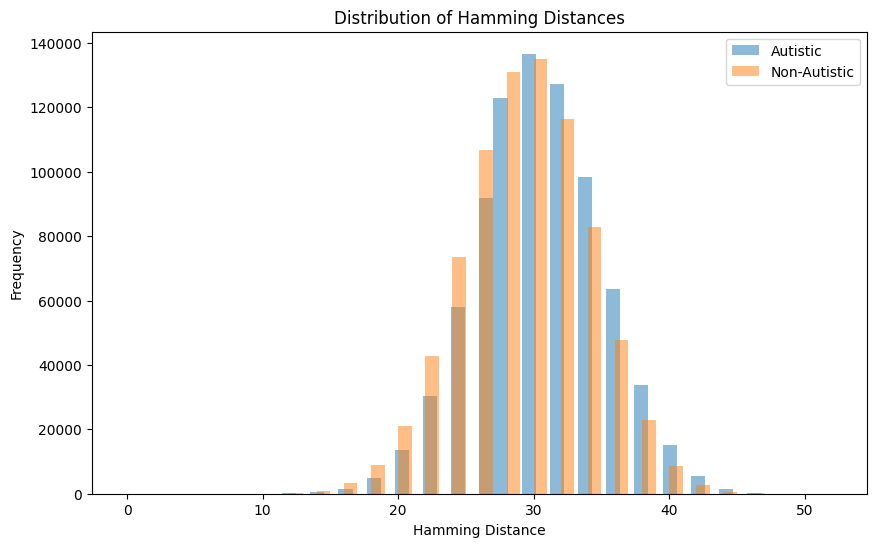

In [6]:
# Convert hashes to binary
df['binary_hash'] = df['hash'].apply(lambda x: bin(int(x, 16))[2:].zfill(64))

# Function to calculate Hamming distance
def hamming_distance(hash1, hash2):
    return sum(c1 != c2 for c1, c2 in zip(hash1, hash2))

# Calculate Hamming distances within each class
autistic_hashes = df[df['class'] == 'Autistic']['binary_hash'].tolist()
non_autistic_hashes = df[df['class'] == 'Non_Autistic']['binary_hash'].tolist()

autistic_distances = [hamming_distance(autistic_hashes[i], autistic_hashes[j]) 
                      for i in range(len(autistic_hashes)) 
                      for j in range(i+1, len(autistic_hashes))]

non_autistic_distances = [hamming_distance(non_autistic_hashes[i], non_autistic_hashes[j]) 
                          for i in range(len(non_autistic_hashes)) 
                          for j in range(i+1, len(non_autistic_hashes))]

# Calculate statistics
autistic_mean = np.mean(autistic_distances)
non_autistic_mean = np.mean(non_autistic_distances)
autistic_std = np.std(autistic_distances)
non_autistic_std = np.std(non_autistic_distances)



# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(autistic_distances, bins=50, alpha=0.5, label='Autistic')
plt.hist(non_autistic_distances, bins=50, alpha=0.5, label='Non-Autistic')
plt.xlabel('Hamming Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Hamming Distances')
plt.legend()
plt.show()


## Hexadecimal to integer conversion

In [7]:
df['hash_int'] = df['hash'].apply(lambda x: int(str(x), 16))

# Separate the hash values by class
autistic_hashes = df[df['class'] == 'Autistic']['hash_int']
non_autistic_hashes = df[df['class'] == 'Non_Autistic']['hash_int']


## Statistical Testing on Hash values

### 1. T-Test

In [8]:
# Perform a two-sample t-test
t_stat, p_value = ttest_ind(autistic_hashes, non_autistic_hashes)

# Set significance level
alpha = 0.05

# Print results
print(f'Test Statistic: {t_stat}')
print(f'P-Value: {p_value}')
if p_value < alpha:
    print('\nAccepted hypothesis: \n\tThere is a significant difference in average hash values between the two classes.\n\tThe images in the two classes are perceptually distinct.')
else:
    print('Rejected hypothesis: \nThere is no significant difference in average hash values between the two classes.')


Test Statistic: 5.869863931344302
P-Value: 4.930186501122452e-09

Accepted hypothesis: 
	There is a significant difference in average hash values between the two classes.
	The images in the two classes are perceptually distinct.


### 2. Wilcoxon Rank-Sum Test

In [9]:
# Perform Wilcoxon rank-sum test (Mann-Whitney U)
statistic, pval = ranksums(autistic_hashes, non_autistic_hashes)

# Print the results
print(f"Wilcoxon Rank-Sum Statistic: {statistic}")
print(f"P-Value: {pval}")

# Interpret the results
if pval < alpha:
    print("\nAccepted hypothesis.:\n\tThere is a significant difference in the distributions of hash values between 'Autistic' and 'Non_Autistic' classes.\n\tThe images in the two classes are perceptually distinct.")
else:
    print("Rejected hypothesis.:\n\tThere is no significant difference in the distributions of hash values between 'Autistic' and 'Non_Autistic' classes.")


Wilcoxon Rank-Sum Statistic: 5.530889140181124
P-Value: 3.186116458422831e-08

Accepted hypothesis.:
	There is a significant difference in the distributions of hash values between 'Autistic' and 'Non_Autistic' classes.
	The images in the two classes are perceptually distinct.
